# Comparison - Data generators


Behavior in high-dimensional spaces between several data generators:
- DENSIRED - ours
- MDCGen by Felix/Arthur
- make_blobs by sklearn
- gaussian quantiles by sklearn

# Table of contents
1. [DENSIRED](#densired)
2. [Evaluation area](#eval)
3. [Hyoerparameter Tuning - SCAR](#scar)
4. [Intrinsic Dimensionality](#intrinsic)

---

## Data Generator - DENSIRED <a name="densired"></a>

In [2]:
import numpy as np
import pandas as pd
import random
import math
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
from collections import deque
from tqdm import tqdm
import seaborn as sns
sns.set

from pyparsing import nestedExpr

import warnings
warnings.filterwarnings("ignore")

In [3]:
def set_seed(i):
    np.random.seed(i)

In [4]:
# obtain n uniformly sampled points within a d-sphere with a fixed radius around a given point. Assigns all points to given cluster
# code partially based on code provided here http://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/
def random_ball_num(center, radius, d, n, clunum):
    d = int(d)
    n = int(n)
    u = np.random.normal(0,1,(n,d+1))  # an array of d normally distributed random variables
    norm=np.sqrt(np.sum(u**2,1))
    r = np.random.random(n)**(1.0/d)
    normed = np.divide(u,norm[:, None])
    x= r[:, None]*normed
    x[:,:-1] = center + x[:,:-1]*radius
    x[:,-1] = clunum
    return x

In [5]:
# obtain n uniformly sampled points within a d-sphere with a fixed radius around a given point. Does not assign all points to given cluster
def random_ball_num_noclu(center, radius, d, n):
    u = np.random.normal(0,1,(n,d))  # an array of d normally distributed random variables
    norm=np.sqrt(np.sum(u**2,1))
    r = np.random.random(n)**(1.0/d)
    normed = np.divide(u,norm[:, None])
    x= r[:, None]*normed
    x = center + x*radius
    return x

In [6]:
# detect if point within minimal distance of a set of points
def tooclose (pos, cluid, points, labels, factors, mindist, d):
    #if (len(points) > 0):
    #    points = points[0]
    for j in range(len(points)):
        x = points[j]
        label = labels[j]
        factor = max(factors[label], factors[cluid])
        dist = 0
        mindistj = mindist * factor
        for i in range(d):
            dist += (x[i] - pos[i]) ** 2
            if dist **0.5 > mindistj:
                break
        if dist **0.5 < mindistj:
            return True
    return False

In [7]:
# obtain index of closesest point
def getclosest (pos, points, startdist, d):
    #if (len(points) > 0):
    #    points = points[0]
    mindist = startdist
    minj = 0
    for j in range(len(points)):
        x = points[j]
        dist = 0
        for i in range(d):
            dist += (x[i] - pos[i]) ** 2
            if dist **0.5 > mindist:
                break
        if dist **0.5 < mindist:
            mindist = dist ** 0.5
            minj = j
            
    return minj


In [8]:
class densityDataGen:
    def __init__(self, dim=2, clunum=2, clu_ratios=None, core_num=10, min_ratio=0, ratio_noise=0, domain_size=1,
                 radius=1, shift=1, ratio_con=0, connections=0, seed=0, dens_factors=False, stickiness=0,
                 con_stickiness=0.9, min_dist=1.1, con_min_dist=0.9, shift_spread=0, max_retry=5, verbose=False,
                 safety=True, con_dens_factors=False, con_radius=2, con_shift=2, branch=0, star=0, square=False,
                 random_start=False):

        set_seed(seed)
        self.verbose = verbose
        self.dim = dim
        self.clunum = clunum
        self.clu_ratios = clu_ratios
        self.core_num = core_num
        self.min_ratio = min_ratio
        self.ratio_noise = ratio_noise
        self.domain_size = domain_size
        self.r_sphere = radius
        self.r_shift = shift
        self.ratio_con = ratio_con
        self.connections = connections
        self.c_sphere = con_radius
        self.c_shift = con_shift

        self.con_dens_factors = con_dens_factors
        self.dens_factors = dens_factors
        self.shift_spread = shift_spread
        self.max_retry = max_retry
        self.stickiness = stickiness
        self.con_stickiness = con_stickiness
        self.min_dist = min_dist
        self.con_min_dist = con_min_dist
        self.safety = safety

        self.cores = {}
        self.value_space = []
        self.mins = [domain_size + 1] * self.dim
        self.maxs = [-1] * self.dim

        self.stream_content = []
        self.stream_repeat = []
        self.stream_data_cores_block = {}
        self.stream_num_block = {}
        self.noise_block = {}
        self.cur_stream_point = 0
        self.cur_stream_pos = 0
        self.cur_stream_db = {}

        self.cur_block_num = 0
        self.in_reapeat = False

        self.branch = branch
        self.star = star

        self.square = square
        self.random_start = random_start

        self.data_ratio = 1 - ratio_con - ratio_noise
        if (self.data_ratio <= 0):
            raise BaseException("No data points can be generated")

        if self.clu_ratios == None:
            while (True):
                self.clu_ratios = np.sort(np.random.random(self.clunum - 1) * self.data_ratio)
                self.clu_ratios = np.append(self.clu_ratios, 1)
                dist = 0
                newrun = False
                for i in range(self.clunum):
                    if i == 0:
                        dist = self.clu_ratios[i]
                    elif i == self.clunum - 1:
                        dist = self.data_ratio - self.clu_ratios[i - 1]
                        self.clu_ratios[i] = self.data_ratio
                    else:
                        dist = self.clu_ratios[i] - self.clu_ratios[i - 1]
                    if dist < self.min_ratio:
                        newrun = True
                        break
                if not newrun:
                    break
        elif (self.clunum == len(self.clu_ratios)):
            prior_ratio = 0
            new_ratio = []
            for ratio in self.clu_ratios:
                ratio = ratio + prior_ratio
                new_ratio.append(ratio)
                prior_ratio = ratio

            self.clu_ratios = np.divide(new_ratio, ratio / self.data_ratio)
        else:
            raise BaseException("Shape of cluster ratio does not match cluster number")

        if self.dens_factors == False:
            self.dens_factors = []
            for _ in self.clu_ratios:
                self.dens_factors.append(1)
        elif self.dens_factors == True:
            self.dens_factors = []
            for _ in self.clu_ratios:
                factor = (np.random.rand() * 1.5) + 0.5
                factor = round(factor, 2)
                # print(factor)
                self.dens_factors.append(factor)
        elif (self.clunum != len(self.dens_factors)):
            raise BaseException("Shape of cluster scale factors does not match cluster number")

        if type(self.branch) is list:
            if (self.clunum != len(self.branch)):
                raise BaseException("Shape of branch chances does not match cluster number")
        elif self.branch == "Rand":
            self.branch = []
            for _ in self.clu_ratios:
                branch = np.random.rand() * 0.5
                self.branch.append(branch)
        else:
            branch = self.branch
            self.branch = [branch] * self.clunum

        if type(self.star) is list:
            if (self.clunum != len(self.star)):
                raise BaseException("Shape of star chances does not match cluster number")
        elif self.star == "Rand":
            # print("I was here")
            self.star = []
            for _ in self.clu_ratios:
                star = np.random.rand() * 0.5
                self.star.append(star)
        else:
            star = self.star
            self.star = [star] * self.clunum

        if (self.verbose):
            print("Cluster size ratios:")
            print(self.clu_ratios)
            print("Cluster scale factors:")
            print(self.dens_factors)

        if type(self.stickiness) is list:
            if (self.clunum != len(self.stickiness)):
                raise BaseException("Shape of cluster stickiness does not match cluster number")
            else:
                if (self.verbose):
                    print("Cluster stickiness factors:")
                    print(self.stickiness)
        elif self.stickiness == True:
            self.stickiness = []
            for _ in self.clu_ratios:
                stickiness = np.random.rand()
                self.stickiness.append(stickiness)
            if (self.verbose):
                print("Cluster stickiness factors:")
                print(self.stickiness)
        else:
            stickiness = self.stickiness
            self.stickiness = [stickiness] * self.clunum

        if type(self.core_num) is list:
            if (self.clunum != len(self.core_num)):
                raise BaseException("Shape of cluster core number does not match cluster number")
            else:
                if (self.verbose):
                    print("Cluster core numbers:")
                    print(self.core_num)

        connection_starts = []
        connection_stops = []

        if type(self.connections) is list:
            for con in self.connections:
                # print(con)
                pair = con.split(";")
                # print(pair)
                # print(pair[0])
                connection_starts.append(int(pair[0]))
                connection_stops.append(int(pair[1]))
        else:
            for i in range(self.connections):
                startclu = np.random.choice(len(range(self.clunum)), 1)
                stopclu = np.random.choice(len(range(self.clunum)), 1)
                while (stopclu == startclu):
                    stopclu = np.random.choice(len(range(self.clunum)), 1)
                connection_starts.extend(startclu)
                connection_stops.extend(stopclu)

        if self.con_dens_factors == None or self.con_dens_factors == False:
            self.con_dens_factors = []
            for _ in range(len(connection_starts)):
                self.con_dens_factors.append(1)
        elif self.con_dens_factors == True:
            self.con_dens_factors = []
            for _ in range(len(connection_starts)):
                factor = (np.random.rand() * 1.5) + 0.5
                factor = round(factor, 2)
                self.con_dens_factors.append(factor)
        elif (len(connection_starts) != len(self.con_dens_factors)):
            raise BaseException("Shape of connection scale factors does not match connection number")

        if type(self.con_stickiness) is list:
            if (len(connection_starts) != len(self.con_stickiness)):
                raise BaseException("Shape of connection stickiness does not match connection number")
        elif self.con_stickiness == True:
            self.con_stickiness = []
            for _ in range(len(connection_starts)):
                con_stickiness = np.random.rand()
                self.con_stickiness.append(con_stickiness)
        else:
            con_stickiness = self.con_stickiness
            self.con_stickiness = [con_stickiness] * len(connection_starts)

        if verbose:
            for i in range(len(connection_starts)):
                print("Connection from " + str(connection_starts[i]) + " to " + str(
                    connection_stops[i]) + " with factor " + str(self.con_dens_factors[i]) + " and stickiness " + str(
                    self.con_stickiness[i]))

        for cluid in range(self.clunum):
            self.generate_cluster(cluid)

        self.connections = {}
        for i in range(len(connection_starts)):
            retry = 0
            conid = -i - 2
            # print("connection " + str(conid))
            while (True):
                noretry = self.make_connection(connection_starts[i], connection_stops[i], conid)
                if noretry:
                    self.connections[conid] = str(connection_starts[i]) + "-" + str(connection_stops[i])

                    if len(self.cores[conid]) == 0:
                        if retry >= self.max_retry:
                            self.cores.pop(conid, None)
                            if (self.verbose):
                                print("Could not generate connection from " + str(connection_starts[i]) + " to " + str(
                                    connection_stops[i]) + " as they were too close")
                            break
                        else:
                            retry += 1
                    else:
                        break
                if retry >= self.max_retry:
                    self.cores.pop(conid, None)
                    if (self.verbose):
                        print("Could not generate connection from " + str(connection_starts[i]) + " to " + str(
                            connection_stops[i]))
                    break
                else:
                    retry += 1

    def generate_cluster(self, cluid):
        retry = 0
        no_space = self.random_start

        #print(self.cores)
        while (True):

            if cluid == 0 or cluid == 1 or no_space:
                pos = np.random.random(self.dim) * self.domain_size
                if self.verbose:
                    print(f"{cluid}: random start")
            else:
                midids = np.random.choice(range(cluid), 2, replace=False)
                #print(midids)
                #core1 = np.sum(self.cores[midids[0]], axis=0)/len(self.cores[midids[0]])#[np.random.choice(len(self.cores[midids[0]]))]
                #core2 = np.sum(self.cores[midids[1]], axis=0)/len(self.cores[midids[1]])#[np.random.choice(len(self.cores[midids[1]]))]
                core1 = self.cores[midids[0]][np.random.choice(len(self.cores[midids[0]]))]
                core2 = self.cores[midids[1]][np.random.choice(len(self.cores[midids[1]]))]

                pos = (core1 + core2) / 2
                #print(pos)
                if self.verbose:
                    print(f"{cluid}: average start between {midids[0]} and {midids[1]}")
            self.cores[cluid] = []
            noretry = self.generate_cluster_pos(pos, cluid)
            if noretry:
                break
            elif (retry >= self.max_retry and no_space):  # expand domain size, at some point there is enough space for new cluster
                self.domain_size = self.domain_size + self.r_sphere
                retry = 0
                if (self.verbose):
                    print(f"{cluid}: domain size increased")
            elif retry >= self.max_retry and not no_space:
                retry = 0
                no_space = True
                if self.verbose:
                    print(f"{cluid}: restart random")
            else:
                if (self.verbose):
                    print(f"{cluid}: restart")
                retry += 1
        self.cores[cluid] = np.array(self.cores[cluid])

    def make_connection(self, startid, stopid, conid):
        startcore = self.cores[startid][np.random.choice(len(self.cores[startid]))]
        stopcore = self.cores[stopid][np.random.choice(len(self.cores[stopid]))]

        conind = conid * -1 - 2
        # print("conind: " + str(conind))

        coni_stickiness = self.con_stickiness
        if type(self.con_stickiness) is list:
            coni_stickiness = self.con_stickiness[conind]

        dist = np.sum((stopcore - startcore) ** 2) ** (0.5)

        pos = startcore
        self.cores[conid] = []
        self.cores[conid].append(pos)
        pos_old = pos

        min_dist = (self.con_dens_factors[conind] * self.c_sphere + self.dens_factors[
            stopid] * self.r_sphere) * self.con_min_dist
        retry_some = False
        tries_some = -1
        while (dist > min_dist):
            # print(dist)
            retry_last = True
            tries_last = 0
            while (retry_last or retry_some):

                if (retry_some):
                    shift_dir_old = None

                    if (len(self.cores[conid])) <= 1:
                        startcore = self.cores[startid][np.random.choice(len(self.cores[startid]))]
                        pos = startcore
                        self.cores[conid] = []
                        self.cores[conid].append(pos)
                        pos_old = pos
                    else:
                        old_id = np.random.choice(len(self.cores[conid]))

                        # print(old_id)
                        # print(len(self.cores[conid]))

                        pos_old = self.cores[conid][old_id]

                        self.cores[conid] = self.cores[conid][:old_id]

                    tries_some += 1
                    retry_some = False

                shift_dir = (np.random.random(self.dim) - 0.5)
                shift_dir = shift_dir / np.linalg.norm(shift_dir)

                guided = stopcore - pos_old

                shift_dir = shift_dir * (1 - coni_stickiness) + (guided * coni_stickiness)
                shift_dir = shift_dir / np.linalg.norm(shift_dir)

                c_shift_clu = self.c_shift * self.con_dens_factors[conind]
                max_rand = 1.5
                min_rand = 2 / 3
                shift_randomness = max(min_rand, min(max_rand, np.random.normal(1, self.shift_spread, 1)))
                # print(shift_randomness)
                pos = pos_old + shift_dir * c_shift_clu * shift_randomness

                dist = np.linalg.norm(stopcore - pos)

                for c in self.cores[stopid]:
                    dist = min(dist, np.linalg.norm(c - pos))

                attempts = 0

                if (self.tooclose(pos, conid, exclude=[startid, stopid, conid])):
                    # print("too close")
                    if (tries_some >= self.max_retry):
                        return False
                    elif (tries_last >= self.max_retry):
                        retry_some = True
                        tries_last = 0
                    else:
                        tries_last += 1
                else:
                    self.cores[conid].append(pos)
                    pos_old = pos
                    shift_dir_old = shift_dir
                    retry_last = False

                    for d in range(self.dim):
                        self.mins[d] = min(pos[d] - self.c_sphere * self.con_dens_factors[conind], self.mins[d])
                        self.maxs[d] = max(pos[d] + self.c_sphere * self.con_dens_factors[conind], self.maxs[d])

        connectors = []
        for c in self.cores[conid]:
            if not (self.tooclose_pair(c, conid, startid) or self.tooclose_pair(c, conid, stopid)):
                connectors.append(c)

        if len(connectors) > 0:
            constart = connectors[0]
            target = startcore

            dist = np.linalg.norm(startcore - constart)

            for c in self.cores[startid]:
                cdist = np.linalg.norm(c - constart)
                if dist > cdist:
                    dist = cdist
                    target = c

            guided = constart - target
            shift_dir = guided / np.linalg.norm(guided)

            pos = target + (self.con_dens_factors[conind] * self.c_sphere + self.dens_factors[
                startid] * self.r_sphere) * shift_dir * self.con_min_dist

            connectors = deque(connectors)
            connectors.appendleft(pos)
            connectors = list(connectors)

            constop = connectors[-1]
            target = stopcore

            dist = np.linalg.norm(stopcore - constop)

            for c in self.cores[stopid]:
                cdist = np.linalg.norm(c - constop)
                if dist > cdist:
                    dist = cdist
                    target = c

            guided = constop - target
            shift_dir = guided / np.linalg.norm(guided)

            pos = target + (self.con_dens_factors[conind] * self.c_sphere + self.dens_factors[
                stopid] * self.r_sphere) * shift_dir * self.con_min_dist

            connectors.append(pos)

        self.cores[conid] = np.array(connectors)
        return True

    def tooclose(self, pos, label, exclude=None, noise=False):
        # if (len(points) > 0):
        #    points = points[0]

        #print(self.cores)

        if exclude is None:
            exclude = [label]

        for cluid in self.cores.keys():
            if cluid not in exclude:
                # print(cluid)
                if cluid < -1:
                    factor = self.con_dens_factors[cluid * -1 - 2] * self.c_sphere
                else:
                    factor = self.dens_factors[cluid] * self.r_sphere

                if label < -1:
                    factor += self.con_dens_factors[label * -1 - 2] * self.c_sphere
                elif not noise:
                    factor += self.dens_factors[label] * self.r_sphere
                elif self.safety:
                    factor += factor
                else:
                    factor += 0.1 * factor

                if label < -1:
                    min_distcluid = self.con_min_dist * factor
                else:
                    min_distcluid = self.min_dist * factor
                # print(min_distcluid)
                for core in self.cores[cluid]:
                    dist = 0
                    for i in range(self.dim):
                        dist += (core[i] - pos[i]) ** 2
                        if dist ** 0.5 > min_distcluid:
                            break
                    if dist ** 0.5 < min_distcluid:
                        return True
        return False

    def tooclose_pair(self, pos, label, partner):
        factor1 = 0
        if label >= 0:
            factor1 = self.dens_factors[label] * self.r_sphere
        else:
            factor1 = self.con_dens_factors[label * -1 - 2] * self.c_sphere
        factor2 = 0
        if partner >= 0:
            factor2 = self.dens_factors[partner] * self.r_sphere
        else:
            factor2 = self.con_dens_factors[partner * -1 - 2] * self.c_sphere

        factor = factor1 + factor2

        if label < -1:
            min_distcluid = self.con_min_dist * factor
        else:
            min_distcluid = self.min_dist * factor
        if label < 0 or partner < 0:
            min_distcluid = self.con_min_dist * factor

            # print(str(factor1) + " " + str(factor2) + " " + str(factor) + " " + str(min_distcluid))
        for core in self.cores[partner]:
            dist = 0
            for i in range(self.dim):
                dist += (core[i] - pos[i]) ** 2
                if dist ** 0.5 > min_distcluid:
                    break
            if dist ** 0.5 < min_distcluid:
                return True
        return False

    def generate_cluster_pos(self, start_pos, cluid):

        if self.tooclose(start_pos, cluid):
            return False

        clu_stickiness = self.stickiness
        if type(self.stickiness) is list:
            clu_stickiness = self.stickiness[cluid]

        core_num = 0
        if type(self.core_num) is list:
            core_num = self.core_num[cluid]
        else:
            clu_ratio = 0
            if cluid >= 1:
                clu_ratio = self.clu_ratios[cluid] - self.clu_ratios[cluid - 1]
            else:
                clu_ratio = self.clu_ratios[cluid]
            core_num = max(round((clu_ratio) * self.core_num / self.data_ratio), 1)

        if (self.verbose):
            print("Cluster ID " + str(cluid) + " Core Number: " + str(core_num))
        pos = start_pos
        self.cores[cluid].append(pos)
        pos_old = pos
        shift_dir_old = None

        branch_chance = self.branch[cluid]
        star_chance = self.star[cluid]

        for i in range(core_num - 1):

            retry_last = True
            tries_last = 0
            retry_some = False
            tries_some = -1
            while (retry_last or retry_some):
                rand = np.random.rand()
                if (retry_some or rand < branch_chance):
                    shift_dir_old = None
                    probs = [1 / len(self.cores[cluid])] * len(self.cores[cluid])
                    if star_chance > 0 and len(self.cores[cluid]) > 1:
                        probs = [star_chance]
                        probs.extend([(1 - star_chance) / (len(self.cores[cluid]) - 1)] * (len(self.cores[cluid]) - 1))

                    selected = np.random.choice(len(self.cores[cluid]), p=probs)
                    # print(selected)
                    pos_old = self.cores[cluid][selected]
                    tries_some += 1
                    retry_some = False

                shift_dir = (np.random.random(self.dim) - 0.5)
                shift_dir = shift_dir / np.linalg.norm(shift_dir)
                if shift_dir_old is not None:
                    shift_dir = shift_dir * (1 - clu_stickiness) + (shift_dir_old * clu_stickiness)
                shift_dir = shift_dir / np.linalg.norm(shift_dir)
                # print(shift_dir)

                r_shift_clu = self.r_shift * self.dens_factors[cluid]
                max_rand = 1.5
                min_rand = 2 / 3
                shift_randomness = max(min_rand, min(max_rand, np.random.normal(1, self.shift_spread, 1)))
                # print(shift_randomness)
                pos = pos_old + shift_dir * r_shift_clu * shift_randomness
                attempts = 0

                if (self.tooclose(pos, cluid)):
                    if (tries_some >= self.max_retry):
                        return False
                    elif (tries_last >= self.max_retry):
                        retry_some = True
                        tries_last = 0
                    else:
                        tries_last += 1
                else:
                    self.cores[cluid].append(pos)
                    pos_old = pos
                    shift_dir_old = shift_dir
                    retry_last = False

                    for d in range(self.dim):
                        self.mins[d] = min(pos[d] - self.r_sphere * self.dens_factors[cluid], self.mins[d])
                        self.maxs[d] = max(pos[d] + self.r_sphere * self.dens_factors[cluid], self.maxs[d])

            # while(tooclose(pos, clunum-1, center_store_other, center_clunum, clufactors, (r_sphere*2.5), d)):
            #    if (attempts > 100):
            #        pos_old = startpos
            #        attempts = 0
            #        print("reset to startpos")
            # print("tooclose")
            #    shift_dir = np.random.random(d) - 0.5
            #    pos = pos_old + (shift_dir/(np.sum(shift_dir**2) **(0.5))*np.random.normal(r_shift, shiftwidth, 1))
            #    attempts = attempts + 1

        return True

    def generate_data(self, data_num):
        testsum = 0
        mins = []
        maxs = []
        data = []

        con_core_num = 0
        for cluid in self.cores.keys():
            if cluid < -1:
                con_core_num += len(self.cores[cluid])

        for cluid in self.cores.keys():
            cluratio = 0
            # print(self.clu_ratios[cluid])
            cluradius = self.r_sphere * self.dens_factors[cluid]

            if cluid >= 1:
                clu_ratio = self.clu_ratios[cluid] - self.clu_ratios[cluid - 1]
            elif cluid == 0:
                clu_ratio = self.clu_ratios[cluid]
            else:
                clu_ratio = self.ratio_con * len(self.cores[cluid]) / con_core_num
                cluradius = self.c_sphere * self.con_dens_factors[-1 * cluid - 2]

            clu_core_num = len(self.cores[cluid])

            # print(cluid)
            clu_data_num = round(clu_ratio * data_num)
            testsum += clu_data_num
            assignment = np.random.choice(clu_core_num, clu_data_num)
            assignment_counter = Counter(assignment)
            for coreid in range(len(self.cores[cluid])):
                core = self.cores[cluid][coreid]
                core_data_num = assignment_counter[coreid]
                if (core_data_num == 0 and self.safety):
                    core_data_num = 1
                # print(str(coreid) + " " + str(core_data_num))
                data_new = random_ball_num(core, cluradius, self.dim, core_data_num, cluid)
                data.extend(data_new.tolist())

        noisenum = round(data_num * self.ratio_noise)
        noise = np.random.random([noisenum, self.dim + 1])

        maxall = -1 * np.inf
        minall = np.inf
        if self.square:
            for d in range(self.dim):
                if maxall < self.maxs[d]:
                    maxall = self.maxs[d]
                if minall > self.mins[d]:
                    minall = self.mins[d]
            dspan = maxall - minall
            for d in range(self.dim):
                noise[:, d] = (noise[:, d] * dspan * 1.2) + minall - 0.1 * dspan
        else:
            for d in range(self.dim):
                dspan = self.maxs[d] - self.mins[d]

                noise[:, d] = (noise[:, d] * dspan * 1.2) + self.mins[d] - 0.1 * dspan

        noise[:, -1] = -1
        truenoise = []
        for n in noise:
            while (self.tooclose(n, -1, noise=True)):
                n = np.random.random([self.dim + 1])
                for d in range(self.dim):
                    dspan = self.maxs[d] - self.mins[d]
                    n[d] = (n[d] * dspan * 1.2) + self.mins[d] - 0.1 * dspan
                    n[-1] = -1
            truenoise.append(n)

            # print("noise removed")

        data.extend(truenoise)
        # print(len(data))

        if not self.safety:
            while (len(data) > data_num):
                data.pop()
                print(len(data))

        return np.array(data)

    def paint(self, dim1, dim2, data=None, show_radius=True, show_core=True, cores=None):
        if cores is None:
            cores = self.cores

        num_col = max(self.cores.keys()) - min(0, min(self.cores.keys())) + 2
        color = plt.cm.tab20(np.linspace(0, 1, num_col))
        plt.figure(figsize=(15, 15))
        if data is not None:
            plt.scatter(data[:, dim1], data[:, dim2], color=color[data[:, len(data[0]) - 1].astype('int32') + 1],
                        alpha=1)

        legend = []

        for cluid in cores.keys():
            if len(cores[cluid]) > 0:
                if self.verbose:
                    if cluid >= 0:
                        patch = mpatches.Patch(color=color[cluid + 1], label=cluid)
                        legend.append(patch)
                    else:
                        patch = mpatches.Patch(color=color[cluid + 1], label=self.connections[cluid])
                        legend.append(patch)
                # print(self.cores[cluid])
                if show_core:
                    if data is None:
                        plt.scatter(cores[cluid][:, dim1], cores[cluid][:, dim2], color=color[cluid + 1], alpha=1)
                    else:
                        plt.scatter(cores[cluid][:, dim1], cores[cluid][:, dim2], color='black', alpha=1)
                if show_radius:
                    for core in cores[cluid]:
                        # print(core[0])
                        if cluid >= 0:
                            plt.gca().add_patch(mpatches.Circle((core[dim1], core[dim2]),
                                                                radius=self.r_sphere * self.dens_factors[cluid],
                                                                color=color[cluid + 1], alpha=0.2))
                        else:
                            plt.gca().add_patch(mpatches.Circle((core[dim1], core[dim2]),
                                                                radius=self.c_sphere * self.con_dens_factors[
                                                                    (-1 * cluid) - 2], color=color[cluid + 1],
                                                                alpha=0.2))

        if data is not None:
            if -1 in data[:, len(data[0]) - 1]:
                patch = mpatches.Patch(color=color[0], label="Noise")
                legend.append(patch)

        plt.axis('scaled')

        dspan1 = self.maxs[dim1] - self.mins[dim1]
        dspan2 = self.maxs[dim2] - self.mins[dim2]
        plt.xlim(self.mins[dim1] - 0.1 * dspan1, self.maxs[dim1] + 0.1 * dspan1)
        plt.ylim(self.mins[dim2] - 0.1 * dspan2, self.maxs[dim2] + 0.1 * dspan2)

        plt.ylabel(dim2 + 1)

        plt.xlabel(dim1 + 1)
        if self.verbose:
            plt.legend(handles=legend)
            # plt.ylim(50,100)
            # plt.xlim(0,50)
        plt.show()

    def display_data(self, data, show_radius=False, show_core=False, dims=None, dcount=2):
        if (self.dim == 2):
            self.paint(0, 1, data=data, show_radius=show_radius, show_core=show_core)
        elif dims is not None:
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2, data=data, show_radius=show_radius, show_core=show_core)
        else:
            diff = []
            for d in range(self.dim):
                diff.append(self.maxs[d] - self.mins[d])

            # print(diff)
            dims = np.argsort(diff)[:dcount]
            # print(dims)
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2, data=data, show_radius=show_radius, show_core=show_core)

    def display_cores(self, dims=None, dcount=2):
        # print(self.cores)
        if (self.dim == 2):
            self.paint(0, 1)
        elif dims is not None:
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2)
        else:
            diff = []
            for d in range(self.dim):
                diff.append(self.maxs[d] - self.mins[d])

            # print(diff)
            dims = np.argsort(diff)[:dcount]
            # print(dims)
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2)

    def display_cores_selected(self, cores, dims=None, dcount=2):
        if (self.dim == 2):
            self.paint(0, 1, cores=cores)
        elif dims is not None:
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2, cores=cores)
        else:
            diff = []
            for d in range(self.dim):
                diff.append(self.maxs[d] - self.mins[d])

            # print(diff)
            dims = np.argsort(diff)[:dcount]
            # print(dims)
            for d1 in dims:
                for d2 in dims:
                    if d1 < d2:
                        self.paint(d1, d2, cores=cores)

    def toggle_verbose(self):
        self.verbose = not self.verbose

    def init_stream(self, command="", default_duration=1000):

        # command_repeats = nestedExpr('[',']').parseString('[' + str(command) + ']').asList()

        command = command + " "
        block = 0
        loopcount = 0
        loopstart = {}
        loopstop = {}

        curLoopId = 0

        data_cores_block = {}
        data_cores_block[0] = {}
        num = {}

        noise_block = {0: 0}
        num_block = {}

        nested_loop = {}

        loopstart[0] = 0

        i = 0
        while i < len(command):
            # print(i)
            # print(command[i])

            if command[i] == "(":
                curLoopId += 1
                loopstart[curLoopId] = block
                # print("start seen " + str(curLoopId))

            elif command[i] == ")":

                curLoopStopId = len(loopstart) - 1
                while curLoopStopId in loopstop.keys():
                    curLoopStopId -= 1

                loopstop[curLoopStopId] = block
                if i < len(command) - 1:
                    if command[i + 1] == "{":
                        j = 2
                        num_loop = ""
                        while command[i + j] != "}":
                            num_loop = num_loop + command[i + j]
                            j += 1
                        num_loop = int(num_loop)
                        i = i + j
                        num[curLoopStopId] = num_loop
                    else:
                        num[curLoopStopId] = 'x'
                else:
                    num[curLoopStopId] = 'x'
            elif command[i] == "|":
                if command[i + 1] == "{":
                    j = 2
                    c_block = ""
                    while command[i + j] != "}":
                        c_block = c_block + command[i + j]
                        j += 1
                    c_block = int(c_block)
                    i = i + j
                    num_block[block] = c_block
                else:
                    num_block[block] = default_duration

                block += 1
                data_cores_block[block] = {}
                noise_block[block] = 0

            elif command[i] == "n":
                noise_block[block] = 1

            elif command[i].isnumeric() or command[i] == "-":
                cid = command[i]
                if command[i] == "-":
                    cid += command[i + 1]
                    i += 1
                while command[i + 1].isnumeric():
                    cid = cid + command[i]
                    i += 1
                cid = int(cid)
                if command[i + 1] == "c":
                    i += 2
                    eid = command[i]
                    while command[i + 1].isnumeric():
                        eid = eid + command[i]
                        i += 1
                    eid = int(eid)

                    for conkey in self.connections.keys():
                        if (self.connections[conkey] == str(cid) + "-" + str(eid) or self.connections[conkey] == str(
                                eid) + "-" + str(cid)):
                            cid = conkey

                # print(self.cores.keys())
                # print(command[i+1])

                if (command[i + 1] == "["):
                    j = 2
                    # print("I was here")
                    # print(block)
                    # print(cid)

                    # print(data_cores_block[block])
                    data_cores_block[block][cid] = []
                    # print(data_cores_block[block][cid])

                    while command[i + j] != "]":
                        if command[i + j] != ",":
                            cstartid = command[i + j]
                            while command[i + j + 1].isnumeric():
                                cstartid = cstartid + command[i + j + 1]
                                j += 1
                            cstartid = int(cstartid)

                            if command[i + j + 1] == ":":
                                j += 2
                                cstopid = command[i + j]

                                while command[i + j + 1].isnumeric():
                                    cstopid = cstopid + command[i + j + 1]
                                    j += 1
                                cstopid = int(cstopid)
                                data_cores_block[block][cid].extend(np.arange(cstartid, cstopid + 1).tolist())
                            else:
                                data_cores_block[block][cid].append(cstartid)
                        j += 1
                    i = i + j
                else:
                    data_cores_block[block][cid] = np.arange(len(self.cores[cid])).tolist()
            i += 1

        loopstop[0] = block
        num[0] = 1

        if block not in num_block.keys():
            num_block[block] = default_duration

        for l in range(len(loopstart)):
            startl = loopstart[l]
            stopl = loopstop[l]
            l2 = l + 1
            nested_loop[l] = []
            while l2 in range(len(loopstart)) and loopstart[l2] <= stopl:
                nested_loop[l].append(l2)
                l2 += 1
        for l in nested_loop.keys():
            prune = []
            for l2 in nested_loop[l]:
                for l3 in nested_loop[l]:
                    if l3 in nested_loop[l2]:
                        prune.append(l3)
            update = []
            for l2 in nested_loop[l]:
                if l2 not in prune:
                    update.append(l2)
            nested_loop[l] = update

        content = {}
        remaining_loops = len(nested_loop)

        print(num)
        for i in num.keys():
            if len(num.keys()) < 2:
                break
            elif i != list(num.keys())[-2]:
                if num[i] == 'x':
                    num[i] = 2
            else:
                if num[i] == 'x':
                    if loopstop[i] != block:
                        num[0] = 'x'
                        num[i] = 2

        # print(loopstart)
        # print(loopstop)
        # print(num)
        print(data_cores_block)
        # print(num_block)
        # print(noise_block)
        # print(nested_loop)

        while remaining_loops > 0:

            # print(remaining_loops)
            for lk in nested_loop.keys():
                if len(nested_loop[lk]) > 0 and not lk in content.keys():
                    wait = False
                    for lk2 in nested_loop[lk]:
                        if not lk2 in content.keys():
                            wait = True
                    if not wait:
                        startb = loopstart[lk]
                        stopb = loopstop[lk]
                        content[lk] = []
                        for lk2 in nested_loop[lk]:
                            repeats = 1
                            content[lk].extend(np.arange(startb, loopstart[lk2]).tolist())
                            if num[lk2] != 'x':
                                repeats = num[lk2]
                            for j in range(repeats):
                                content[lk].extend(content[lk2])
                            startb = loopstop[lk2] + 1
                        remaining_loops -= 1
                        if startb < stopb + 1:
                            content[lk].extend(np.arange(startb, stopb + 1).tolist())

                        # print(str(lk) + " done: " + str(remaining_loops))
                else:
                    if not lk in content.keys():
                        content[lk] = np.arange(loopstart[lk], loopstop[lk] + 1).tolist()
                        remaining_loops -= 1
                        # print(str(lk) + " done: " + str(remaining_loops))

        # print(content)

        repeat = ""
        if not len(num.keys()) < 2:
            finalloop = list(num.keys())[-2]
            if num[finalloop] == 'x':
                repeat = content[finalloop]
            elif loopstop[finalloop] != block:
                repeat = [block]
            else:
                repeat = content[0]
        else:
            repeat = [block]

        # print(final)

        self.stream_content = content[0]
        self.stream_repeat = repeat
        self.stream_data_cores_block = data_cores_block
        self.stream_num_block = num_block
        self.noise_block = noise_block

        self.cur_stream_point = 0
        self.cur_stream_pos = 0
        # self.prev_block_num = 0
        self.in_repeat = False
        self.cur_block_num = 0
        self.cur_stream_dist = {}
        if len(num_block) > 0:
            self.cur_block_num = num_block[0]
            self.cur_stream_dist = {}

        return content[0], repeat, data_cores_block, num_block, noise_block

    def display_stream(self, command="", default_duration=1000, show_core=True, show_radius=True):
        self.init_stream(command=command, default_duration=default_duration)
        self.display_current_stream(command, default_duration, show_core, show_radius)

    def display_current_stream(self, command="", default_duration=1000, show_core=True, show_radius=True):

        points = 0

        for block in self.stream_content:
            # print(block)
            # print(data_cores_block[block])
            # print(num_block[block])

            block_cores = {}
            for cluid in self.stream_data_cores_block[block].keys():
                block_cores[cluid] = self.cores[cluid][self.stream_data_cores_block[block][cluid]]
            self.display_cores_selected(block_cores)

    def __iter__(self):
        return self

    def __next__(self):
        recalc_db = False

        if self.cur_stream_point == 0 and self.cur_stream_pos == 0:
            recalc_db = True

        self.cur_stream_point += 1

        if not self.in_repeat:
            block = self.stream_content[self.cur_stream_pos]

            if self.cur_stream_point > self.cur_block_num:
                self.cur_stream_pos += 1
                self.cur_stream_point = 1

                if self.cur_stream_pos >= len(self.stream_content):
                    self.in_repeat = True
                    self.cur_stream_pos = 0
                    block = self.stream_repeat[self.cur_stream_pos]
                    print("repeat")
                else:
                    print("generates from block: " + str(self.cur_stream_pos))
                    block = self.stream_content[self.cur_stream_pos]
                self.cur_block_num = self.stream_num_block[block]
                recalc_db = True
        else:
            block = self.stream_repeat[self.cur_stream_pos]
            if self.cur_stream_point > self.cur_block_num:
                self.cur_stream_pos += 1
                self.cur_stream_point = 1

                if self.cur_stream_pos >= len(self.stream_repeat):
                    self.cur_stream_pos = 0
                block = self.stream_repeat[self.cur_stream_pos]
                self.cur_block_num = self.stream_num_block[block]
                recalc_db = True
        if recalc_db:
            block_db = {}

            con_core_num = 0
            for cluid in self.stream_data_cores_block[block].keys():
                if cluid < -1:
                    con_core_num += len(self.stream_data_cores_block[block][cluid])

            db_sum = 0
            for cluid in self.stream_data_cores_block[block].keys():
                if cluid >= 1:
                    block_db[cluid] = self.clu_ratios[cluid] - self.clu_ratios[cluid - 1]
                elif cluid == 0:
                    block_db[cluid] = self.clu_ratios[cluid]
                else:
                    block_db[cluid] = self.ratio_con * len(self.stream_data_cores_block[block][cluid]) / con_core_num
                db_sum += block_db[cluid]

            for cluid in block_db.keys():
                block_db[cluid] = (block_db[cluid] / db_sum) * (1 - self.noise_block[block] * self.ratio_noise)

            if self.noise_block[block] == 1:
                block_db[-1] = self.ratio_noise
            self.cur_stream_db = block_db

        cluid_choice = np.random.choice(list(self.cur_stream_db.keys()), 1, p=list(self.cur_stream_db.values()))[0]

        # self.cores[cluid][self.stream_data_cores_block[block][cluid]]
        if cluid_choice == -1:
            n = np.random.random([self.dim + 1])
            for d in range(self.dim):
                dspan = self.maxs[d] - self.mins[d]
                n[d] = (n[d] * dspan * 1.2) + self.mins[d] - 0.1 * dspan
                n[-1] = -1
            while (self.tooclose(n, -1, noise=True)):
                n = np.random.random([self.dim + 1])
                for d in range(self.dim):
                    dspan = self.maxs[d] - self.mins[d]
                    n[d] = (n[d] * dspan * 1.2) + self.mins[d] - 0.1 * dspan
                    n[-1] = -1
            return n
        else:
            core_choice = np.random.choice(self.stream_data_cores_block[block][cluid_choice])
            core_chosen_pos = self.cores[cluid_choice][core_choice]
            cluradius = 0
            if cluid_choice >= 0:
                cluradius = self.r_sphere * self.dens_factors[cluid_choice]
            else:
                cluradius = self.c_sphere * self.con_dens_factors[-1 * cluid_choice - 2]
            return random_ball_num(core_chosen_pos, cluradius, self.dim, 1, cluid_choice)[0]

#: parallel
|: next ts
(...): repeat
[]: subset, corenums, seperated by , for actual, : for sequence
{}: actual number, not cluster, for repeats and ts
n: noise
xcy: from connection between x and y 
-: not


"1[2:10,30:35];1[30:35]"

In [28]:
x = densityDataGen(dim=2, ratio_noise = 0, clunum= 3, seed = 5, 
                   connections=2, con_radius=3, con_shift=3, ratio_con = 0.1, shift=1,shift_spread=1,
                   verbose = True, core_num = 100, mindist=1, con_mindist = 1, 
                   con_stickyness=0.8, domain_size=100,safety=False)
# dense region, deal with them?
# x.display_stream("(1#2#1c2|{2000}2#n|0|0[8,10:15,17:18]){3}|((1#2|(2#n))|(1|2))")
#x.display_stream("0|0[8:10]|0")
#1.c1c2c3c4c5c6
#1.c2c3c4
# x.display_cores()
data = x.generate_data(50000)
#data2 = x.generate_data(2000)
x.display_data(data, True, False)
#x.display_data(data2, False, False)

TypeError: densityDataGen.__init__() got an unexpected keyword argument 'mindist'

## Data Generator von N. Schüler

<font color='red'>Code not working!</font>

In [ ]:
import numpy as np
import math
import random
from sklearn.datasets import make_blobs

def generate_subspacedata(n=0, d=0, mu_clu=False, subspaces=None):
    if n == 0 or d == 0:
        print_instructions()
        return None, None
    elif subspaces is None:
        #print("I will generate random subspaces...")
        return random_subspaces(n, d, mu_clu)
    else:
        subspace_cluster = np.zeros((n, d))
        subspace_lables = np.zeros((n, d))
        empty_space = []
        empty_rows = 0
        n_pointer = 0
        needed_dim = -1
        number_sub_clusters = 0
        for sub in subspaces:
            # print(str(sub) + " und der ganze Rest: "+str(d_space)+" und "+str(n_pointer))
            number_sub_clusters = number_sub_clusters + 1
            sub_n = sub[0]
            sub_d = sub[1]
            c = sub[2]
            std = sub[3]
            x, y = make_subspaceblob(sub_n, sub_d, c, std)
            if sub_d <= d:
                if sub_n <= (n - n_pointer):
                    for i in range(0, len(x)):
                        for j in range(0, len(x[0])):
                            subspace_cluster[i+n_pointer][j] = x[i][j]
                            subspace_lables[i+n_pointer][j] = number_sub_clusters
                        empty_space.append(sub_d)
                    n_pointer = n_pointer + sub_n
                else:
                    # place behind other clusters if enabled
                    if mu_clu:
                        while len(empty_space) < d:
                            empty_space.append(0)
                        #print(empty_space)
                        for l in empty_space:
                            if d - l >= sub_d:
                                empty_rows = empty_rows + 1
                                needed_dim = max(l, needed_dim)
                                if empty_rows >= sub_n:
                                    for i in range(0, len(x)):
                                        for j in range(0, len(x[0])):
                                            subspace_cluster[i][j + needed_dim] = x[i][j]
                                            subspace_lables[i][j + needed_dim] = number_sub_clusters
                        #print(needed_dim)
                    else:
                        print("There are more points in the subspaces than in your dataset!\n"
                              "Either change those numbers or enable points to be in multiple subspaces by adding "
                              "the parameter 'True'.")
            else:
                print("The subspace cluster has more dimensions than your original dataspace.")

        for i in range(0, len(subspace_cluster)):
            for j in range(0, len(subspace_cluster[0])):
                if subspace_cluster[i][j] == 0:
                    subspace_cluster[i][j]= np.random.uniform(-100, 100)
        return subspace_cluster, subspace_lables


def make_subspaceblob(sub_n, sub_d, c, std):
    box = 100
    #print("Making "+str(c)+" subspace cluster(s) with "+str(sub_d)+" dimensions over "+str(sub_n)+" points (std: "+str(std)+").")
    X, y = make_blobs(n_samples=sub_n, n_features=sub_d, centers=c, cluster_std=std, center_box=(-box, box), shuffle=True, random_state=None)
    return X, y


def random_subspaces(n, d, mu_clu):
    subspaces = []
    number_random_clusters = random.randint(1, int(math.sqrt(math.sqrt(n*d))))
    for x in range(number_random_clusters):
        sub_n = random.randint(0.1*n, int(int(n*0.8) / number_random_clusters))
        sub_d = random.randint(0.1*d, int(int(d*0.6) / number_random_clusters))
        c = random.randint(1, int((sub_d / 2)))
        std = random.random()
        subspace = [sub_n, sub_d, c, round(std, 2)]
        subspaces.append(subspace)
    print("Subspaces are: "+ str(subspaces))
    return generate_subspacedata(n, d, mu_clu, subspaces)


In [ ]:
A, lables = generate_subspacedata(10, 10, True)

# Comparison - Evaluation area <a name="eval"></a>

#### load dependencies

In [9]:
from sklearn.datasets import make_blobs, make_gaussian_quantiles, make_circles
from scipy import spatial
from sklearn import preprocessing
import mdcgenpy
from mdcgenpy.clusters import ClusterGenerator
from distance_metric import get_nearest_neighbors

#### Helper fncs

In [10]:
def cosine_dist(p1, p2):
    """
    Calculate the cosine distance between to points in R^n.

    Examples
    --------
    >>> cosine_dist([1, 0], [0, 1])
    90.0
    >>> cosine_dist([1, 0], [2, 0])
    0.0
    >>> cosine_dist([1, 0], [-1, 0])
    180.0
    """
    ang = 1 - spatial.distance.cosine(p1, p2)
    if not (-1 <= ang <= 1):
        if ang >= 1:
            return 0
        if ang <= -1:
            return 180
    return np.degrees(np.arccos(ang))


# np.random.choice(np.arange(0, data_blobs[0].shape[0]), 2)
def get_angles(n, data, num_points=100):
    """Get angles of random points in n-dimensional unit hypercube."""
    # points = 2 * np.random.rand(num_points, n) - 1
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    angles = []
    for p1 in points:
        for p2 in points:
            angles.append(cosine_dist(data[p1], data[p2]))
    return angles


def get_dc_dist(n, data, num_points=100):
    distdc = get_nearest_neighbors(data, 2, min_samples=2)['_all_dists']
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    dists = []
    for p1 in points:
        for p2 in points:
            dists.append(distdc[p1][p2])
    return dists

# np.random.choice(np.arange(0, data_blobs[0].shape[0]), 2)
def get_euclidean_dists(n, data, num_points=100):
    """Get angles of random points in n-dimensional unit hypercube."""
    # points = 2 * np.random.rand(num_points, n) - 1
    points = np.random.choice(np.arange(0, data.shape[0]-1), num_points*2)
    dists = []
    for p1 in points:
        for p2 in points:
            dists.append(np.linalg.norm(data[p2] - data[p1]))
    return dists


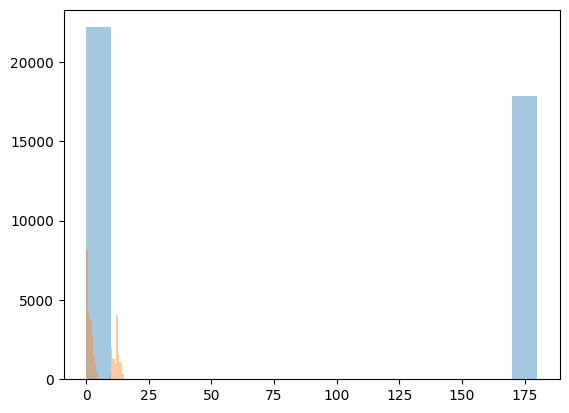

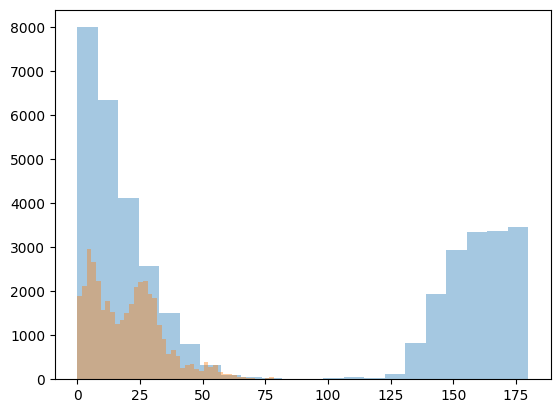

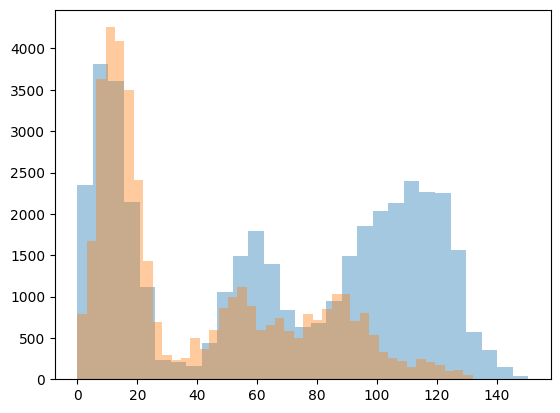

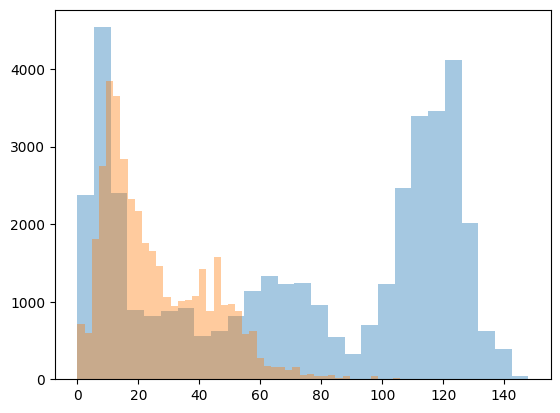

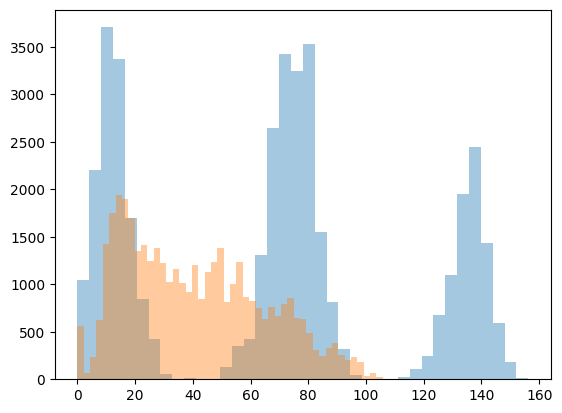

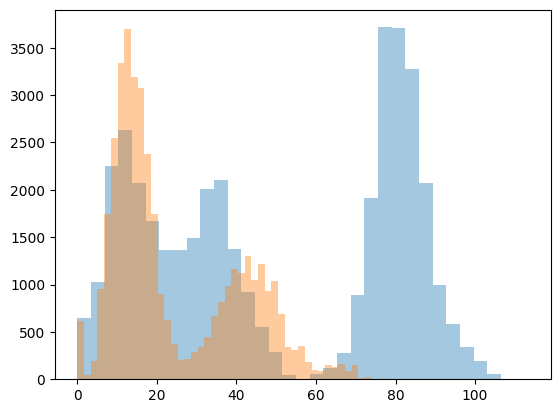

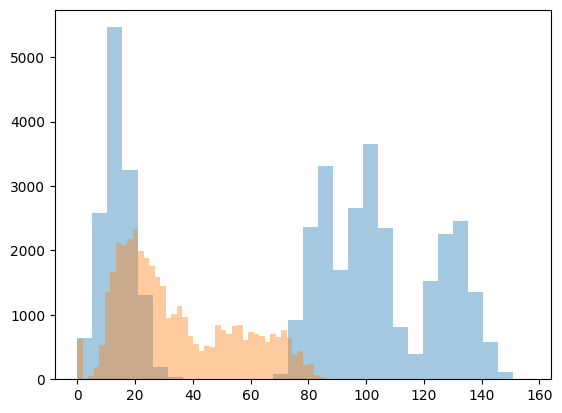

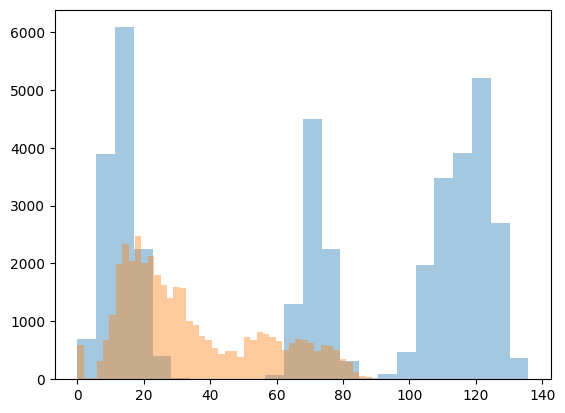

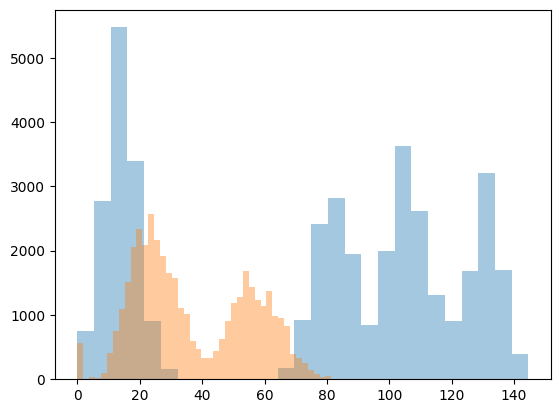

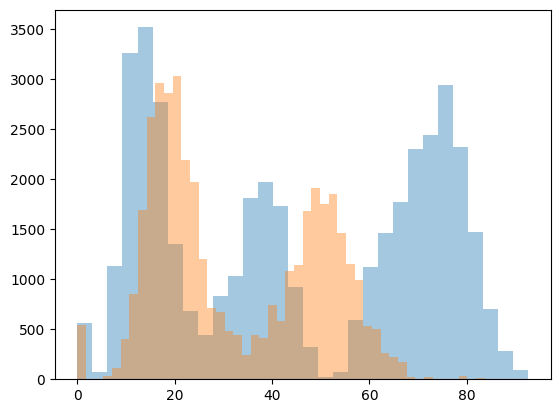

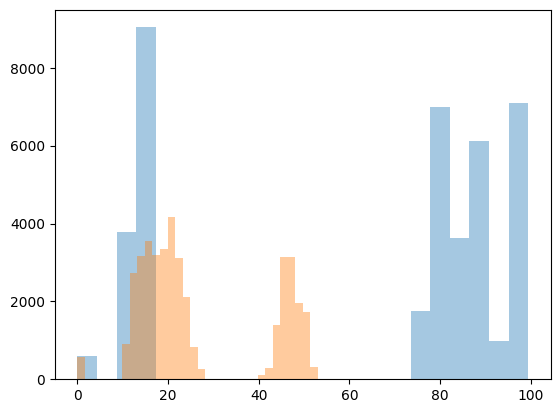

In [19]:
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]:
    n_clusters = 3
    n_samples=100
    
    data_blobs = make_blobs(n_samples=n_samples, n_features=n)
    angles_blobs = get_angles(n, data_blobs[0])

    x = densityDataGen(dim=n, ratio_noise=0, clunum= n_clusters, seed = 5)
    x_data = x.generate_data(n_samples)
    angles_dc = get_angles(n,x_data)
    #print("{:>5} dim: {:0.4f} avg angle".format(n, sum(angles) / len(angles)))
    plt.figure()
    sns.distplot(angles_blobs, kde=False, rug=False)
    sns.distplot(angles_dc, kde=False, rug=False)
    

In [24]:
def compare_generators(x_range=[10, 100, 250, 500], metric="euclidean", 
                       n_iter= 5, n_clusters= 1, n_samples=1000, 
                       plot_distributions=False):
    avg_blobs = []
    avg_gaussian_quantiles = []
    avg_ddg = []
    avg_ddg_star = []
    avg_ddg_branch = []
    avg_mdcgen = []
    
    def _get_avg_dist(dataset):
        if metric == "euclidean":
            dists = get_euclidean_dists(n, dataset)
        elif metric == "cosine":
            dists = get_angles(n, dataset)
        elif metric == "dcdist":
            dists = get_dc_dist(n, dataset) # get_nearest_neighbors(dataset, 2, min_samples=2)['_all_dists']
        else:
            raise NotImplementedError(f"metric {metric} not implemented. \
            Please choose amongst 'euclidean', 'cosine', or 'dcdist'.")
        return dists
    
    def _norm_data(dataset):
        return dataset / np.linalg.norm(dataset, axis=0, keepdims=True)

    for n in tqdm(x_range):
        tmp_blob = 0
        tmp_gaussian = 0
        tmp_ddg = 0
        tmp_ddg_star = 0
        tmp_ddg_branch = 0
        # tmp_ns = 0
        tmp_mdcgen = 0    

        for _ in range(n_iter):
            seed = random.randint(0,10000)

            # BLOBS
            data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
            dists_blobs = _get_avg_dist(_norm_data(data_blobs[0]))
            tmp_blob += (sum(dists_blobs) / len(dists_blobs))

            # GAUSSIAN QUANTILES
            data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
            dists_gquants = _get_avg_dist(_norm_data(data_gquant[0]))
            tmp_gaussian += (sum(dists_gquants) / len(dists_gquants))

            # MDCGenerator - Felix/Arthur
            cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters)
            data_mdcgen = cluster_gen.generate_data()[0]
            dists_mdcgen = _get_avg_dist(_norm_data(data_mdcgen))
            tmp_mdcgen += (sum(dists_mdcgen) / len(dists_mdcgen))        
            
            # density generator - Philipp - default
            x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed) 
            x_data = x.generate_data(n_samples)
            dists_dc = _get_avg_dist(_norm_data(x_data[:, :-1]))
            tmp_ddg += (sum(dists_dc) / len(dists_dc))

            # density generator - Philipp - star
            x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.2, seed=seed)
            x_ddg_star_data = x_ddg_star.generate_data(n_samples)
            dists_dc_star = _get_avg_dist(_norm_data(x_ddg_star_data[:, :-1]))
            tmp_ddg_star += (sum(dists_dc_star) / len(dists_dc_star))

            # density generator - Philipp - branch
            x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=1, seed=seed)
            x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
            dists_dc_branch = _get_avg_dist(_norm_data(x_ddg_branch_data[:, :-1]))
            tmp_ddg_branch += (sum(dists_dc_branch) / len(dists_dc_branch))
            
            if plot_distributions:
                plt.figure()
                sns.distplot(dists_blobs, kde=False, rug=False, label="Blobs")
                sns.distplot(dists_gquants, kde=False, rug=False, label="Gaussian Quantiles")
                sns.distplot(dists_mdcgen, kde=False, rug=False, label="MDCGen")
                sns.distplot(dists_dc, kde=False, rug=False, label="DENSIRED")
                sns.distplot(dists_dc_star, kde=False, rug=False, label=r"DENSIRED$\ast$")
                sns.distplot(dists_dc_branch, kde=False, rug=False, label=r"DENSIRED$^b$")
                plt.legend()

        avg_blobs.append(tmp_blob / n_iter)
        avg_gaussian_quantiles.append(tmp_gaussian / n_iter)
        avg_ddg.append(tmp_ddg / n_iter)
        avg_ddg_star.append(tmp_ddg_star / n_iter)
        avg_ddg_branch.append(tmp_ddg_branch / n_iter)
        avg_mdcgen.append(tmp_mdcgen / n_iter)
        
    return {'blobs': avg_blobs, 
            'gaussian_quantiles': avg_gaussian_quantiles,
            'ddg': avg_ddg, 
            'ddg_star': avg_ddg_star, 
            'ddg_branch': avg_ddg_branch,
            'mdcgen': avg_mdcgen}

In [25]:
def plot(values_dict, xlabel="Dimensions", ylabel="Avg cos distance", 
         x_range=[10, 100, 250, 500], plot_legend=False, fname="plot.png"):
    
    no_entries = len(list(values_dict.values())[0])
    fig = plt.figure(figsize=(6, 2))
    barWidth = 0.15
    n_bars = np.arange(no_entries)
    
    br1 = [x - 2.5*barWidth for x in n_bars]
    br2 = [x - 1.5*barWidth for x in n_bars]
    br3 = [x - 0.5*barWidth for x in n_bars]
    br4 = [x + 0.5*barWidth for x in n_bars]
    br5 = [x + 1.5*barWidth for x in n_bars]
    br6 = [x + 2.5*barWidth for x in n_bars]

    plt.bar(br1, values_dict['blobs'], width = barWidth)
    plt.bar(br2, values_dict['gaussian_quantiles'], width = barWidth)
    plt.bar(br3, values_dict['mdcgen'], width=barWidth)
    plt.bar(br4, values_dict['ddg'], width = barWidth)
    plt.bar(br5, values_dict['ddg_star'], width=barWidth)
    plt.bar(br6, values_dict['ddg_branch'], width=barWidth)

    if plot_legend:
        legend=['Blobs', 'Gaussian Quantiles', 'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$", "MDCGen"]
        plt.legend(legend, loc="lower center",  ncol=3, bbox_to_anchor=(0.5, -0.75))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0,no_entries))
    ax = plt.gca()
    ax.set_xticklabels(x_range[:no_entries])
    plt.savefig(fname, bbox_inches='tight')

#### Start computation for comparison

In [26]:
cos_values = compare_generators(metric="cosine")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:09<00:00, 92.38s/it]


In [27]:
euclid_values = compare_generators(metric="euclidean")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:55<00:00, 58.81s/it]


In [28]:
dc_dist_values = compare_generators(metric="dcdist")

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [1:18:04<00:00, 1171.12s/it]


In [29]:
import pickle 

with open('saved_dictionary_cos_cnum1.pkl', 'wb') as f:
    pickle.dump(cos_values, f)
with open('saved_dictionary_euclid_cnum1.pkl', 'wb') as f:
    pickle.dump(euclid_values, f)
with open('saved_dictionary_dcdist_cnum1.pkl', 'wb') as f: 
    pickle.dump(dc_dist_values, f)

### Plot it!

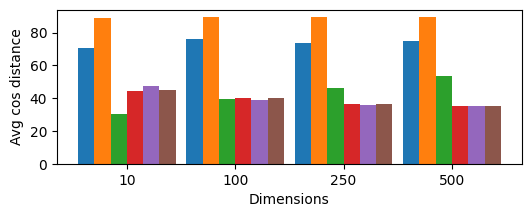

In [18]:
plot(cos_values, plot_legend=False, fname="avg_cosine.png")

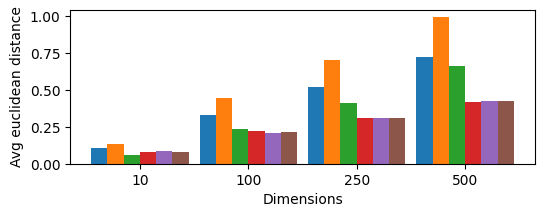

In [25]:
plot(euclid_values, plot_legend=False, ylabel="Avg euclidean distance", fname="avg_euclidean.png")

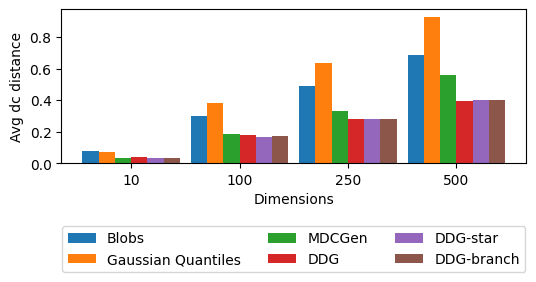

In [26]:
plot(dc_dist_values, plot_legend=True, ylabel="Avg dc distance", fname="avg_dcdist.png")

#### Plotting in one row
for the plot in the paper

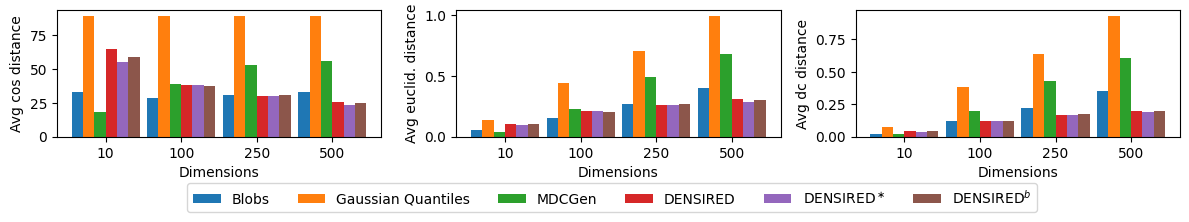

In [31]:
x_range=[10, 100, 250, 500]
fig, axes = plt.subplots(1,3, figsize=(12,2))

# plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.use('default')

for ax, values_dict, y_label in zip(axes, 
                                    [cos_values, euclid_values, dc_dist_values], 
                                    ["Avg cos distance", "Avg euclid. distance", "Avg dc distance"]):
    no_entries = len(list(values_dict.values())[0])
    #fig = plt.figure(figsize=(6, 2))
    barWidth = 0.15
    n_bars = np.arange(no_entries)
    
    br1 = [x - 2.5*barWidth for x in n_bars]
    br2 = [x - 1.5*barWidth for x in n_bars]
    br3 = [x - 0.5*barWidth for x in n_bars]
    br4 = [x + 0.5*barWidth for x in n_bars]
    br5 = [x + 1.5*barWidth for x in n_bars]
    br6 = [x + 2.5*barWidth for x in n_bars]

    ax.bar(br1, values_dict['blobs'], width = barWidth)
    ax.bar(br2, values_dict['gaussian_quantiles'], width = barWidth)
    ax.bar(br3, values_dict['mdcgen'], width=barWidth)
    ax.bar(br4, values_dict['ddg'], width = barWidth)
    ax.bar(br5, values_dict['ddg_star'], width=barWidth)
    ax.bar(br6, values_dict['ddg_branch'], width=barWidth)

    #if plot_legend:
    #    legend=['Blobs', 'Gaussian Quantiles', 'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$", "MDCGen"]
    #    plt.legend(legend, loc="lower center",  ncol=3, bbox_to_anchor=(0.5, -0.75))
    #plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    ax.set_xlabel("Dimensions")
    ax.set_ylabel(y_label)
    #plt.xticks(np.arange(0,no_entries))
    ax.set_xticks(np.arange(0,no_entries))
    # ax = plt.gca()
    ax.set_xticklabels(x_range[:no_entries])

legend=['Blobs', 'Gaussian Quantiles', "MDCGen", 'DENSIRED', r"DENSIRED$^\ast$", r"DENSIRED$^b$"]
plt.tight_layout()
plt.legend(legend, loc="lower center",  ncol=6, bbox_to_anchor=(-0.75, -0.65))
plt.savefig("motivation_small_1.png", bbox_inches='tight')

# SCAR - paramter tuning for running example <a name="scar"></a>

#### Import scar

In [1]:
from SpectralClusteringAcceleratedRobust import SCAR

#### load depdencies

In [ ]:
import time
from sklearn import metrics
import mlflow

mlflow.set_tracking_uri("http://scs-062-bmw-heat.ada.iis.fhg.de:5000/")
mlflow.set_experiment(f'dataGenerator')

In [ ]:
data_1 = np.load("datagenData_22.08.npy")

In [ ]:
data_1.shape
plt.scatter(data_1[:,0], data_1[:,1], c=data_1[:,2])
print (np.unique(data_1[:, 2]))
X, y = np.hsplit(data_1, np.array([2]))
y = y.squeeze()
print (X.shape)
print (y.shape)
sample_size = X.shape[0]

In [ ]:
def calculateClustering(X, y, k, fraction_neighbours, sample_size, thetas, iterations,
                        evaluate_decomposition_methods=False):
    # store results obtained with SCAR (RSC accelerated with Nyström plus further modifications)
    mean_nmi_scar_results = []
    variance_nmi_scar_results = []
    mean_time_scar_results = []
    best_nmi_scar_results = []
    df_scar = pd.DataFrame(columns=["it", 'alpha', 'nn', 'theta', 'nmi', 'time'])
    
    num_neighbours_options = [int(num_neighbours * sample_size) for num_neighbours in fraction_neighbours]
    num_neighbours_options = np.floor(np.linspace(0, 2*math.sqrt(sample_size), 11))[1:].astype(int)
    for _, num_neighbours in enumerate(tqdm(num_neighbours_options, desc="NN-SCAR")):
        for it_idx, alpha_counter in enumerate(tqdm(range(1, 10), desc="Alpha-SCAR")):
            alpha = alpha_counter * subsample_factor
            
            # for _, theta in enumerate(tqdm(thetas, desc="Theta-SCAR")):
            for _, theta in enumerate(thetas):
                nmi_scar_results = []
                time_scar_results = []

                with mlflow.start_run() as run:
                    mlflow.log_param({'alpha': alpha, 'nn': num_neighbours, 'theta': theta, 'model': "scar"})

                    for i in range(iterations):
                        """ calculate robust clustering with Nystrom and other improvements"""
                        start = time.time()
                        clustering_scar = SCAR(k=k, nn=num_neighbours, alpha=alpha, theta=theta, laplacian=0, normalize=True,
                                               weighted=True).fit_predict(X)
                        time_scar = time.time() - start
    
                        nmi_scar = metrics.normalized_mutual_info_score(y, clustering_scar)
                        nmi_scar_results.append(nmi_scar)
                        time_scar_results.append(time_scar)
                        df_scar.loc[len(df_scar)] = [i, alpha, num_neighbours, theta, nmi_scar, time_scar]

                        mlflow.log_metric(f"nmi", nmi_scar, step=i)
                        mlflow.log_metric(f"time", time_scar, step=i)
                        
                mean_nmi_scar_results.append([alpha, num_neighbours, np.mean(nmi_scar_results)])
                best_nmi_scar_results.append([alpha, num_neighbours, np.max(nmi_scar_results)])
                variance_nmi_scar_results.append([alpha, num_neighbours, np.var(nmi_scar_results)])
                mean_time_scar_results.append([alpha, num_neighbours, np.mean(time_scar_results)])

    return df_scar

In [ ]:
subsample_factor = 0.1
iterations = 10                 

result_df = calculateClustering(X, 
                                y, 
                                10, 
                                fraction_neighbours=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4], 
                                sample_size = sample_size,
                                thetas=[100, 250, 500, 1000, 2500, 5000], 
                                iterations=iterations)

In [ ]:
result_df.loc[result_df.nmi.idxmax()]

In [ ]:
pd.set_option("display.max_rows", None)
print (result_df)

In [ ]:
test= result_df.groupby(['alpha', 'nn', 'theta']).mean()['nmi'].idxmax()
# result_df.groupby(['alpha', 'nn', 'theta'])
print (test)

# result_df.groupby(['alpha', 'nn', 'theta']).mean()# .get_group(test)
print (result_df.groupby(['alpha', 'nn', 'theta']).mean().loc[test])

In [ ]:
result_df.to_csv("result.csv")

# Intrinsic Dimensionality <a name="intrinsic"></a>

<Figure size 2400x800 with 0 Axes>

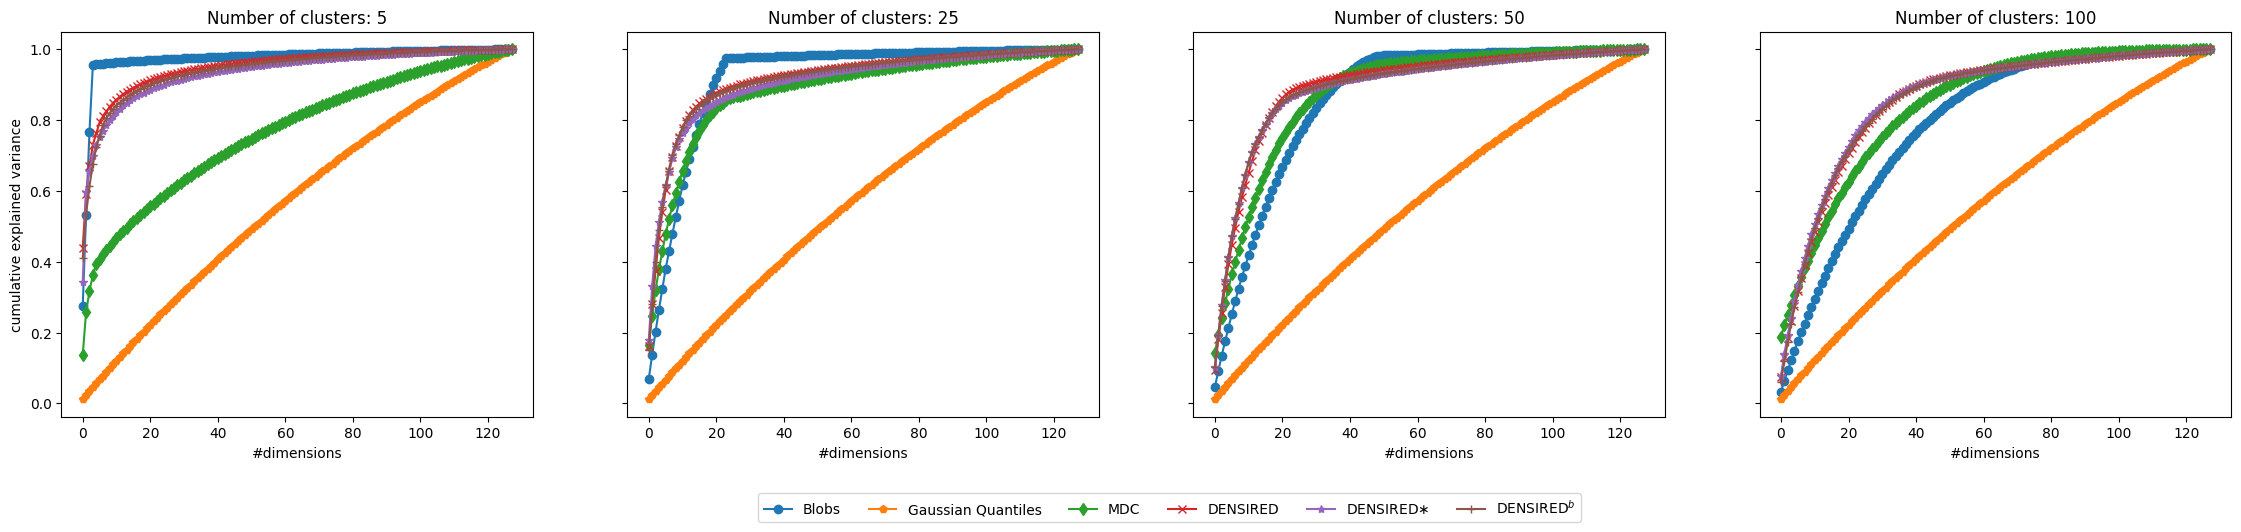

In [21]:
from sklearn.decomposition import PCA

n_samples=2500
n=128
seed=42

fig = plt.figure(figsize=(24,8))

def _norm_data(dataset):
    return dataset / np.linalg.norm(dataset, axis=0, keepdims=True)

f, axes = plt.subplots(1,4, figsize=(28,5), sharey=True)
axes[0].set_ylabel('cumulative explained variance')
for ax, n_clusters in zip(axes,[5,25,50,100]):
    ax.set_xlabel("#dimensions")
    ax.set_title(f"Number of clusters: {n_clusters}")
    
    # BLOBS
    data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
    data_blobs = _norm_data(data_blobs[0])
    pca = PCA().fit(data_blobs)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "o-", label="Blobs")
    
    
    # GAUSSIAN QUANTILES
    data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
    data_gquant = _norm_data(data_gquant[0])
    pca = PCA().fit(data_gquant)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "p-", label="Gaussian Quantiles")
        
    # MDCGenerator - Felix/Arthur
    cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters)
    data_mdcgen = cluster_gen.generate_data()[0]
    data_mdcgen = _norm_data(data_mdcgen)
    pca = PCA().fit(data_mdcgen)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "d-", label="MDC")
        
    # density generator - Philipp - default
    x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed, stickiness=0, core_num=100, random_start = False) 
    # x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, seed=seed) 
    x_data = x.generate_data(n_samples)
    x_data = _norm_data(x_data[:, :-1])
    pca = PCA().fit(x_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "x-" , label="DENSIRED")
    
    # density generator - Philipp - star
    x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.25, stickiness=0.05, core_num=100, seed=seed, random_start = False)
    # x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=1, branch=0.2, seed=seed)
    x_ddg_star_data = x_ddg_star.generate_data(n_samples)
    x_ddg_star_data = _norm_data(x_ddg_star_data[:, :-1])
    pca = PCA().fit(x_ddg_star_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "*-", label=r"DENSIRED$\ast$")
    
    # density generator - Philipp - branch
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=0.2, stickiness=0.1, core_num=100, seed=seed, random_start = False)
    # x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, core_num=20*n_clusters, star=0, branch=0.2, seed=seed)
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    ax.plot(np.cumsum(pca.explained_variance_ratio_), "+-", label=r"DENSIRED$^b$")

plt.legend(loc='upper center', bbox_to_anchor=(-1.25, -0.18), fancybox=True, shadow=False, ncol=6)
plt.savefig("explainedVar_PCA.png", bbox_inches="tight")

(5000, 5)
(5000, 9)
(5000, 17)
(5000, 33)
(5000, 65)
(5000, 129)
(5000, 257)


<Figure size 400x400 with 0 Axes>

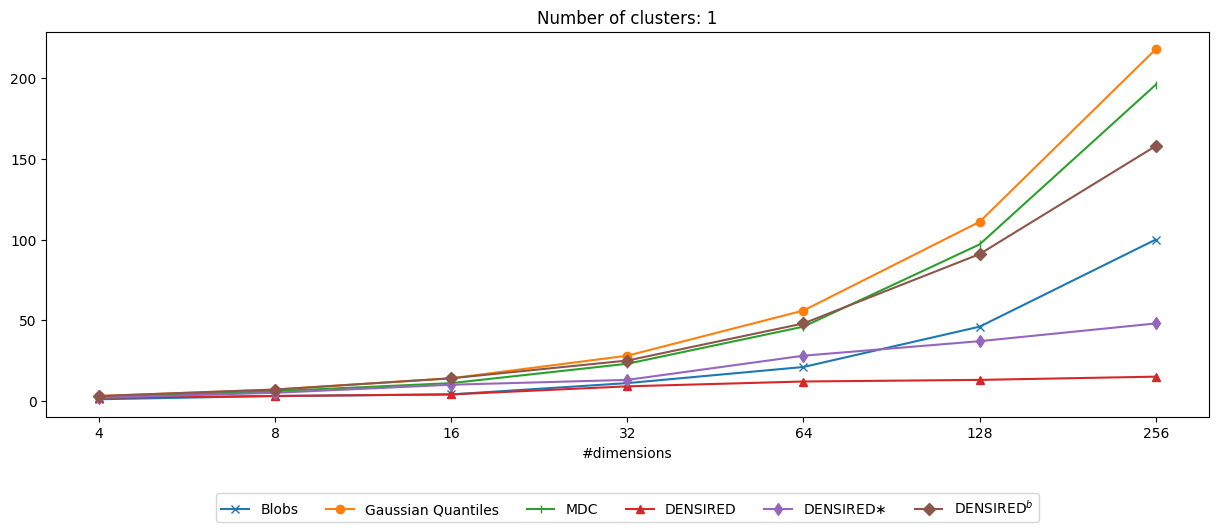

In [19]:
from sklearn.decomposition import PCA

n_samples=5000
n=128
seed=42
n_clusters=1
var_threshold=0.9

fig = plt.figure(figsize=(4,4))

def _norm_data(dataset):
    return dataset / np.linalg.norm(dataset, axis=0, keepdims=True)

f, ax = plt.subplots(1,1, figsize=(15,5), sharey=True)
axes[0].set_ylabel('cumulative explained variance')

res_blobs = []
res_gaussian = []
res_mdc = []
res_densired = []
res_densired_star = []
res_densired_branch = []

# for idx, (ax, n) in enumerate(zip(axes,[4,8,16,32])):
n_features=[4,8,16,32,64, 128, 256]
for idx, n in enumerate(n_features):
    ax.set_xlabel("#dimensions")
    ax.set_title(f"Number of clusters: {n_clusters}")
    
    # BLOBS
    data_blobs = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n)
    data_blobs = _norm_data(data_blobs[0])
    pca = PCA().fit(data_blobs)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_blobs.append(first_idx)
    # ax.scatter(idx, first_idx, label="Blobs")
    
    # GAUSSIAN QUANTILES
    data_gquant = make_gaussian_quantiles(n_samples=n_samples, n_features=n)
    data_gquant = _norm_data(data_gquant[0])
    pca = PCA().fit(data_gquant)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_gaussian.append(first_idx)
    # ax.scatter(idx, first_idx, label="Gaussian Quantiles")
        
    # MDCGenerator - Felix/Arthur
    cluster_gen = mdcgenpy.clusters.ClusterGenerator(n_samples=n_samples, n_feats=n, k=n_clusters)
    data_mdcgen = cluster_gen.generate_data()[0]
    data_mdcgen = _norm_data(data_mdcgen)
    pca = PCA().fit(data_mdcgen)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_mdc.append(first_idx)
    # ax.scatter(idx, first_idx, label="MDC")
        
    # density generator - Philipp - default
    x = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, seed=seed, stickiness=0, core_num=100, random_start = False ) 
    x_data = x.generate_data(n_samples)
    print (x_data.shape)
    x_data = _norm_data(x_data[:, :-1])
    pca = PCA().fit(x_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired.append(first_idx)
    # ax.scatter(idx, first_idx, label="DENSIRED")
    
    # density generator - Philipp - star
    x_ddg_star = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=1, branch=0.25, stickiness=0.1, core_num=100, seed=seed, random_start = False )
    x_ddg_star_data = x_ddg_star.generate_data(n_samples)
    x_ddg_star_data= _norm_data(x_ddg_star_data[:, :-1])
    pca = PCA().fit(x_ddg_star_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired_star.append(first_idx)
    # ax.scatter(idx, first_idx, label=r"DENSIRED$\ast$")
    
    # density generator - Philipp - branch
    x_ddg_branch = densityDataGen(dim=n, ratio_noise=0, clunum=n_clusters, star=0, branch=0.2, stickiness=0.1, core_num=100, seed=seed, random_start = False )
    x_ddg_branch_data = x_ddg_branch.generate_data(n_samples)
    x_ddg_branch_data = _norm_data(x_ddg_branch_data[:, :-1])
    pca = PCA().fit(x_ddg_branch_data)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    first_idx = np.argwhere(cumsum>=var_threshold)[0][0]
    res_densired_branch.append(first_idx)
    # ax.scatter(idx, first_idx, label=r"DENSIRED$^b$")

x_ticks=np.arange(len(n_features))
ax.plot(x_ticks, res_blobs, marker="x", label="Blobs")
ax.plot(x_ticks, res_gaussian, marker="o", label="Gaussian Quantiles")
ax.plot(x_ticks, res_mdc, marker="|", label="MDC")
ax.plot(x_ticks, res_densired, marker="^", label="DENSIRED")
ax.plot(x_ticks, res_densired_star, marker="d", label=r"DENSIRED$\ast$")
ax.plot(x_ticks, res_densired_branch, marker="D", label=r"DENSIRED$^b$")
# ax.set_xticks(n_features)
ax.set_xticklabels([0]+n_features)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), fancybox=True, shadow=False, ncol=6)
plt.savefig("explainedVar2_PCA.png", bbox_inches="tight")

### End of this notebook